# Part 2) EM algorithm and implementation

# A) The parameters of Gaussian Mixture Model (GMM) can be estimated via the EM algorithm. Show that the alternating algorithm for k-means is a special case of the EM algorithm and show the corresponding objective functions for E-step and M-step.

While the GMM algorithm is updated using the probabilities that a datapoint belongs to each cluster, the k - means algorithm is updated solely on the most likely cluster. Therefore, we assume there is 100% chance it belongs to one cluster and 0% chance of belonging to every other cluster at each iteration.

Furthermore, the k-means algorithm treats each feature as indepdent and of equal importance, therefore this is similar to the GMM EM algorithm with spherical covariance meaning it is of the form 𝜎^2*I . Furthermore, we can see that as the variance constant 𝜎^2 approaches zero, the probabilties that datapoint belongs to a cluster calculated during the E step would simplify to 1 if this datapoint is closest to that cluster mean and 0 otherwise. There will be no need to update the covariance matrix in this special case.

Therefore, the E Step is simplified to:

P(Y_i = j | X_i , Theta) = { 1 if j == argmin k = 1,..,K || X_i - 𝜇_k ||^2 }
                           { 0 otherwise }

and for the M step all we have to do is update the cluster means:

𝜇_j = ∑ P(Y_i = j | X_i , Theta) * X_i / ∑ P(Y_i = j | X_i , Theta)




# B) Download the Old Faithful Geyser Dataset. The data file contains 272 observations of (eruption time, waiting time). Treat each entry as a 2 dimensional feature vector. Parse and plot all data points on 2-D plane.

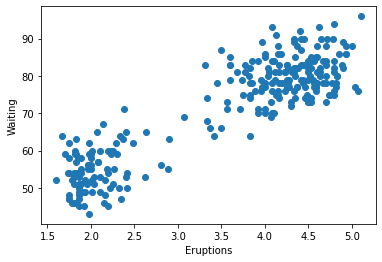

In [28]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

data = []

with open('faithful.dat') as f:
    for line in f:
        clean_line = line.strip("\n")
        word_line = clean_line.split(" ")

        
        line_data = [float(word) for word in clean_line.split(" ")
                     if word != '' and word.replace('.','',1).isdigit()
                     ]
        
        if len(line_data) == 3:
            data.append(line_data[1:])
            
data = np.array(data)

plt.scatter(data[:,0],data[:,1])
plt.xlabel('Eruptions')
plt.ylabel('Waiting')

plt.show()


# C) Implement a bimodal GMM model to fit all data points using EM algorithm. Explain the reasoning behind your termination criteria. For this problem, we assume the covariance matrix is spherical (i.e., it has the form of σ2I for scalar σ) and you can randomly initialize Gaussian parameters. For evaluation purposes, please submit the following figures:

# • Plot the trajectories of two mean vectors in 2 dimensions (i.e., coordinates vs. iteration).

# • Run your program for 50 times with different initial parameter guesses. Show the distribution of the total number of iterations needed for algorithm to converge.




In [816]:
# Main function for GMM-EM algorithm
# Returns the means at each iteration and the final clustering

def GMM_transformation(data, K = 2, spherical = True,
                       threshold = .1,
                       k_means_init = False,
                       plot_init = False
                      ):
    
    # Number of samples
    I = len(data)
    
    # Number of features
    N = len(data[0])
    
    # Initialize parameters
    means = np.zeros((K,N))
    variances = np.zeros((K,N,N))
    alphas = np.array([1/K for k in range(K)])
    
    if k_means_init == False:
        means, variances = initialize_random(data, K, spherical)
        
    else:
        means, variances = initialize_k_means(data, K,
                                              spherical,
                                              plot_init
                                             )

    stop = False
    steps = 0
    last_likelihood = None
    
    mean_steps = [means]
    
    while stop == False:
        # ************ Expectation step: **************
        
        # Get probability of data given parameters
        probs = get_class_probability(data, variances, means)
        
        # ************ Maximization step: **************
            
        # Get log likelihood of data
        likelihood = get_log_likelihood(probs, alphas)

        
        if last_likelihood != None:
            # Not a good enough improvement stop here:
            if likelihood - last_likelihood < threshold:
                stop = True
                continue
        
        last_likelihood = likelihood

        # Get membership weights
        member_weights = get_member_weights(probs, alphas)
        

    
        # Get new parameters
        new_means, new_variances = update_mean_and_variance(data,
                                                    member_weights,
                                                    spherical = spherical
                                                           )
        
        means = new_means
        alphas = np.sum(member_weights, axis = 0) / I


        variances = new_variances
            
        mean_steps.append(means)
        
        steps += 1

    
    clusters = np.argmax(member_weights, axis = 1)
        
    return mean_steps, clusters
        


In [746]:
def initialize_random(data, K, spherical):

    N = len(data[0])
    
    # Initialize parameters
    means = np.zeros((K,N))
    variances = np.zeros((K,N,N))
    
    # The sigma^2 to be used for the spherical covariance matrix
    sigma_start = 20*np.random.random() + 5
    feature_bounds = [[max(data[:,n]), min(data[:,n])] for n in range(N)]

    for k in range(K):
        means[k,:] = [feature_bounds[n][1] + 
                       (feature_bounds[n][0] - feature_bounds[n][1])*np.random.random()
                       for n in range(N)
                      ]
        
        if spherical == True:
            # If spherical, set non diagonals to 0 and use equal variance
            variances[k,:,:] = np.eye(N)*sigma_start

        else:
            
            variances[k,:,:] = [[10*np.random.random() if n == m else 0 for n in range(N)]
                                for m in range(N)
                               ]
            
    return means, variances



In [747]:
def get_log_likelihood(probs, alphas):
    
    total_likelihood = 0
    
    for i in range(len(probs)):

        record_likelihood = np.dot(probs[i,:],alphas)
        
        total_likelihood += np.log(record_likelihood)
        
    return total_likelihood
    

In [697]:

def get_class_probability(data, variances, means):

    I = len(data)
    N = len(data[0])
    K = len(means)
    
    probs = np.zeros((I, K))
    

    for k in range(K):
        base_variance = 1/(np.power(2*np.pi, N/2) *
                           np.power(np.linalg.det(variances[k]), 1/2)
                          )

        variance_inv = np.linalg.inv(variances[k])
 
        for i in range(I):
            mean_diff = np.array(data[i,:] - means[k])[np.newaxis]

            power = np.dot(np.dot(mean_diff, variance_inv), mean_diff.T)[0][0]

            power = (-1/2)*power

            class_prob = base_variance*np.exp(power)

            probs[i,k] = class_prob
            
    return probs

In [748]:
def get_member_weights(probs, alphas):
    I = len(probs)
    K = len(alphas)
    
    
    member_weights = np.zeros((I,K))
    
    for i in range(I):

        num = probs[i,:] * alphas

        denom = np.dot(probs[i,:], alphas)

        class_weights = num / denom

        member_weights[i,:] = class_weights

    return member_weights

In [777]:
def update_mean_and_variance(data, member_weights, spherical = False):
    
    I = len(data)
    N = len(data[0])
    K = len(member_weights[0])


    new_means = np.zeros((K,N))
    new_variances = np.zeros((K,N,N))
    
    
    # Sum total class probabilities
    class_sums = np.sum(member_weights, axis = 0)


    for k in range(K):
        # Sum all weighted vectors
        for i in range(I):
            new_means[k,:] += member_weights[i,k]*data[i,:]

        new_means[k,:] = new_means[k,:]/class_sums[k]

        for i in range(I):
            new_mean_diff = np.array(data[i,:] - new_means[k,:]
                                    )[np.newaxis]

            # If spherical keep covariance matrix in form ~ a*I
            if spherical == True:
                partial_variance = np.eye(N)*np.dot(new_mean_diff,
                                                 new_mean_diff.T)/N
                
            # Else, calculate covariances
            else:
                partial_variance = np.dot(new_mean_diff.T,new_mean_diff)

            new_variances[k,:,:] += member_weights[i,k]*partial_variance
        
        new_variances[k,:,:] = new_variances[k,:,:]/class_sums[k]

    return new_means, new_variances

In [832]:
def plot_mean_steps(mean_steps, data, clusters):
    marker_history = []

    for k in range(len(mean_steps[0])):
        coordinates = []
        for n in range(len(mean_steps[0][0])):
            coordinate = []
            for s in range(len(mean_steps)):
                coordinate.append(mean_steps[s][k][n])

            coordinates.append(coordinate)
            
        coordinates = np.array(coordinates)
        plt.quiver(coordinates[0][:-1], coordinates[1][:-1],
                   coordinates[0][1:]-coordinates[0][:-1],
                   coordinates[1][1:]-coordinates[1][:-1], scale_units='xy', angles='xy', scale=1)
        
    plt.scatter(data[:,0],data[:,1], c = clusters, alpha = .25)

    plt.title("Evolution of the mean vectors at each step. Arrows point to next step")

    plt.show()
    
    

Time: 0.11615514755249023


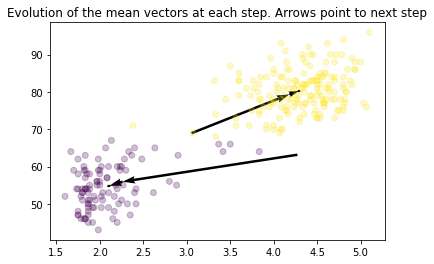

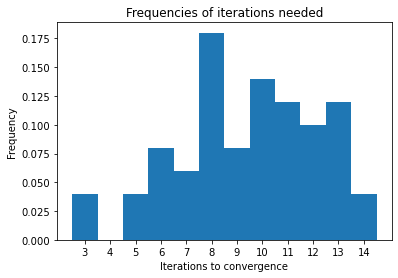

In [840]:
import time as timer

# Run one iteration of the GMM - EM Algo with k-means initialization
t1 = timer.time()
mean_steps, clusters = GMM_transformation(data, K = 2, threshold = .1,
                                spherical = True)

t2 = timer.time()
print("Time: " + str(t2 - t1))

plot_mean_steps(mean_steps, data, clusters)


# Plot the historgram of the # of iterations to convergence 
step_dist = []
for t in range(50):
    mean_steps, clusters = GMM_transformation(data,K = 2,
                                    threshold = .1,
                                    spherical = True
                                   )
    
    step_dist.append(len(mean_steps))
    
    
buckets = [i for i in range(min(step_dist), max(step_dist) + 2)]


plt.hist(step_dist, bins = buckets, density = True, align = 'left')#, align = 'left', rwidth = 1)
plt.xticks(buckets[:-1])
plt.title("Frequencies of iterations needed")
plt.ylabel("Frequency")
plt.xlabel("Iterations to convergence")
plt.show()




# D) Repeat the task in (c) but with the initial guesses of the parameters generated from the following process:

# • Run a k-means algorithm over all the data points with K = 2 and label each point with one of the two clusters.

# • Estimate the first guess of the mean and covariance matrices using maximum likelihood over the labeled data points.

# Compare the algorithm performances of (c) and (d).

In [768]:

# Update the k-means clusters by minimizing the
# within cluster sum of squares distance

def update_clusters(data, clusters, K):
            
    I = len(data)
    N = len(data[0])
    
    means = np.zeros((K, N))
    cluster_distances = np.zeros((I,K))
    
    for k in range(K):
        indices = np.where(clusters == k)
        
        means[k,:] = np.mean(data[indices,:], axis = 1)
        cluster_distances[:,k] = np.linalg.norm(data - means[k,:], axis = 1)

        
    new_clusters = np.argmin(cluster_distances, axis = 1)

    return new_clusters, means
        
        

In [812]:
# Use k means to initialize means and covariance
def initialize_k_means(data, K, spherical, plot_init):
        
    I = len(data)
    N = len(data[0])
    
    # Get random clustering
    clusters = np.random.randint(0,
                                 K,
                                 size = I)

    
    # --------------------------------------------- #
    # Iterate until k means converges
    finished_k_means = False
    
    while finished_k_means == False:
        new_clusters, means = update_clusters(data, clusters, K)

        if np.array_equal(new_clusters, clusters):
            finished_k_means = True
            
        clusters = new_clusters
    
    
    # --------------------------------------------- #
    # Estimate means and covariance matrix using MLE
    # Use labeled points instead of GMM probabilties for first step
    
    # Member weights given by labeled point
    member_weights = np.zeros((I,K))
    for k in range(K):
        member_weights[np.where(new_clusters == k), k] = 1

        
    means, variances = update_mean_and_variance(data,
                                                member_weights,
                                                spherical = spherical)
    
    # --------------------------------------------- #
    if plot_init == True:
        # Plot clustering given by k means
        plt.scatter(data[:,0],data[:,1],
                    c = clusters,
                    alpha = .25)

        plt.title("Clustering given by k-means")
        plt.show()
    
        # Print means and covariance given by MLE:
        print("The initalized mean using MLE is: ")
        print(means)
        print("")
        print("The initialized variance using MLE is: ")
        print(variances)
        
    return means, variances

    

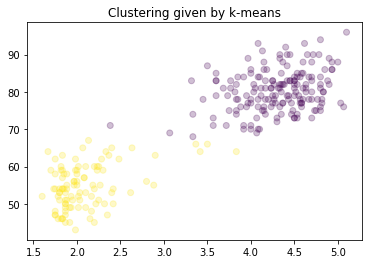

The initalized mean using MLE is: 
[[ 4.29793023 80.28488372]
 [ 2.09433    54.75      ]]

The initialized variance using MLE is: 
[[[15.83020596  0.        ]
  [ 0.         15.83020596]]

 [[17.28088935  0.        ]
  [ 0.         17.28088935]]]
Time: 0.2851870059967041


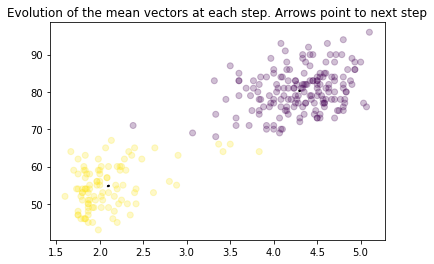

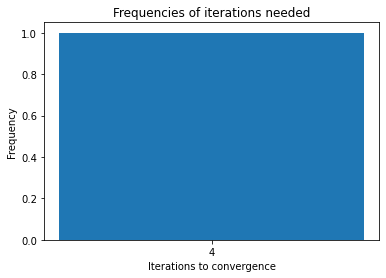

In [843]:

# Run one iteration of the GMM - EM Algo with k-means initialization
t1 = timer.time()

mean_steps, clusters = GMM_transformation(data, K = 2, threshold = .1,
                                spherical = True,
                                k_means_init = True,
                                plot_init = True
                               )
t2 = timer.time()
print("Time: " + str(t2-t1))

plot_mean_steps(mean_steps, data, clusters)


# Plot the historgram of the # of iterations to convergence 
step_dist = []
for t in range(50):
    mean_steps, clusters = GMM_transformation(data, K = 2, threshold = .1,
                                    spherical = False,
                                    k_means_init = True,
                                    plot_init = False
                                   )
    
    step_dist.append(len(mean_steps))

buckets = [i for i in range(min(step_dist), max(step_dist) + 2)]


plt.hist(step_dist, bins = buckets, density = True, align = 'left')#, align = 'left', rwidth = 1)
plt.xticks(buckets[:-1])
plt.title("Frequencies of iterations needed")
plt.ylabel("Frequency")
plt.xlabel("Iterations to convergence")
plt.show()



We see that on this dataset with K = 2, and a log likelihood threshold of 0.1, the final clustering results are very similar. However, we notice that k-menas initialization greatly reduces the number of necessary iterations and speeds up total computation time. Furthermore, we notice that for larger K and for weaker log likelihood thresholds the results begin to diverge and the final results of the randomly initialized versions begin to have more variance.